In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.


References:
1. https://github.com/facebookresearch/segment-anything
2. https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
3. https://github.com/openai/CLIP
4.https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb

# Automatically generating object masks with SAM and Classify masks with CLIP 

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ptsmp268
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ptsmp268
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=2e43fe6f2df6c0af04533af098c61116252274bff4fd044577d762427e10369a
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0nqj41u/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

In [5]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8lackj19
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8lackj19
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=f42dc1a063f252e9793687d20f6de440b549588c12c9ee1abefe040a03cac0e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-c6yb2cxo/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [6]:
!pip install decord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 28.2 MB/s eta 0:00:00


In [8]:
! wget https://storage.googleapis.com/sleap-data/datasets/eleni_mice/clips/20200111_USVpairs_court1_M1_F1_top-01112020145828-0000%400-2560.mp4

--2023-06-09 18:11:51--  https://storage.googleapis.com/sleap-data/datasets/eleni_mice/clips/20200111_USVpairs_court1_M1_F1_top-01112020145828-0000%400-2560.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169822255 (162M) [video/mp4]
Saving to: ‘20200111_USVpairs_court1_M1_F1_top-01112020145828-0000@0-2560.mp4’

20200111_USVpairs_c 100%[===================>] 161.96M  15.4MB/s    in 13s     

2023-06-09 18:12:04 (12.8 MB/s) - ‘20200111_USVpairs_court1_M1_F1_top-01112020145828-0000@0-2560.mp4’ saved [169822255/169822255]



## Set-up

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from pkg_resources import packaging

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [13]:
image = cv2.imread('/content/R2202_02-10-2023_000100275.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

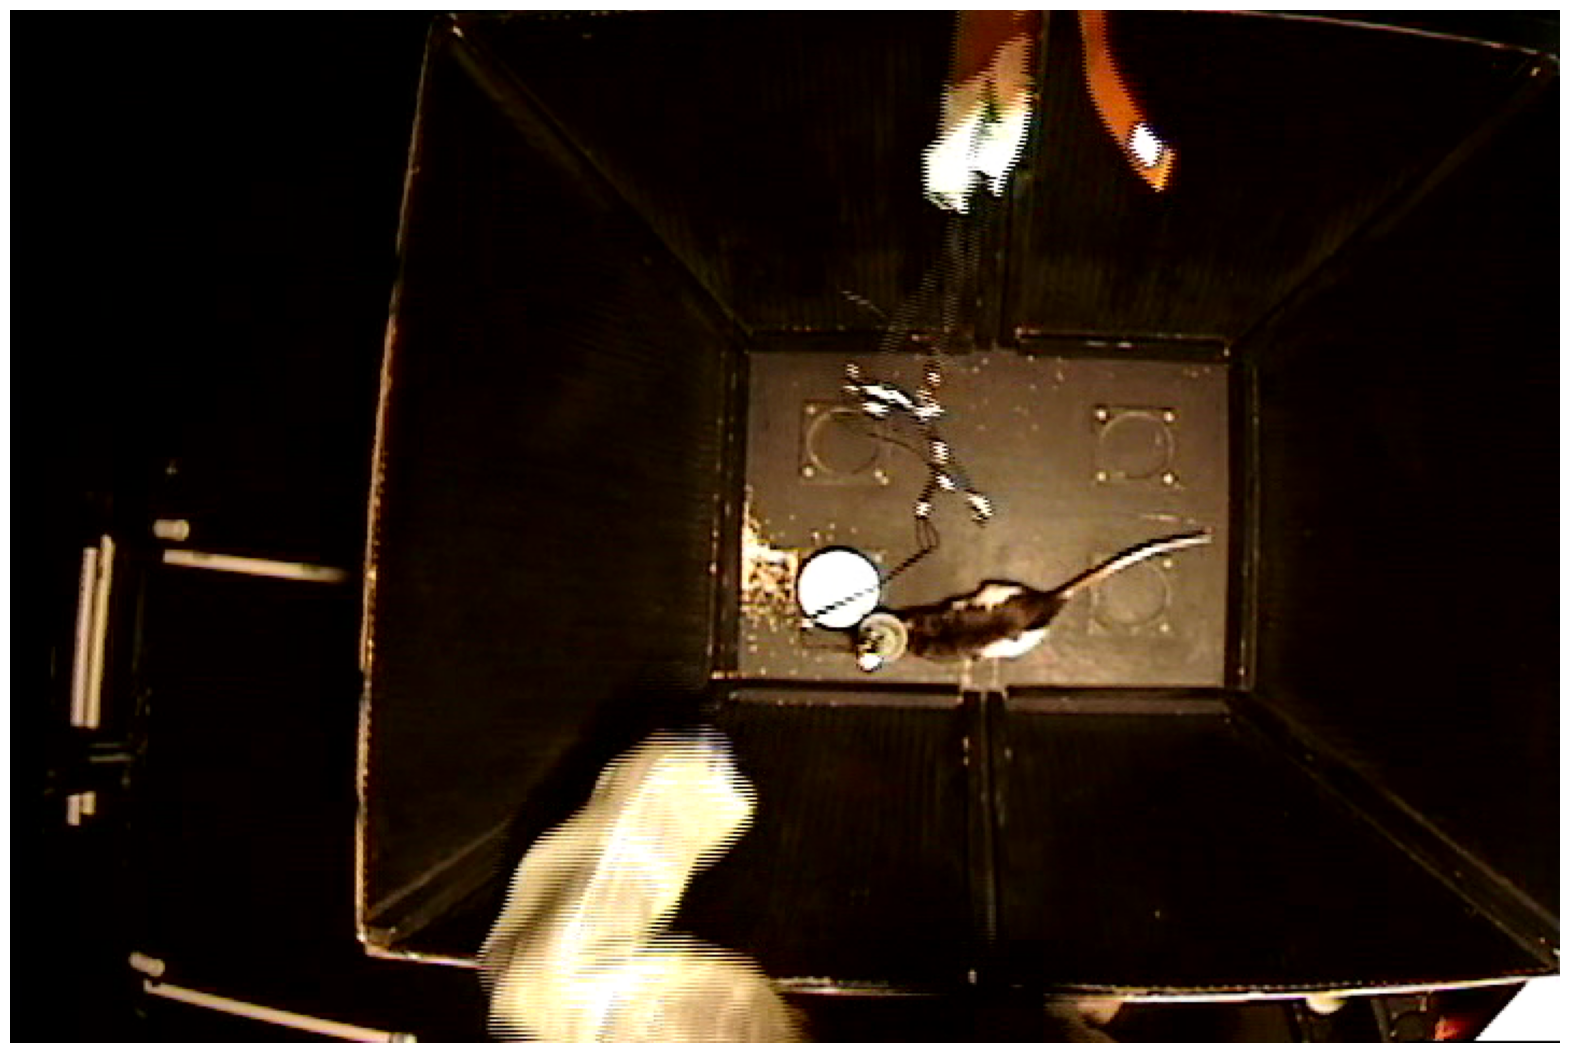

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [16]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [17]:
print(len(masks))
print(masks[0].keys())

40
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

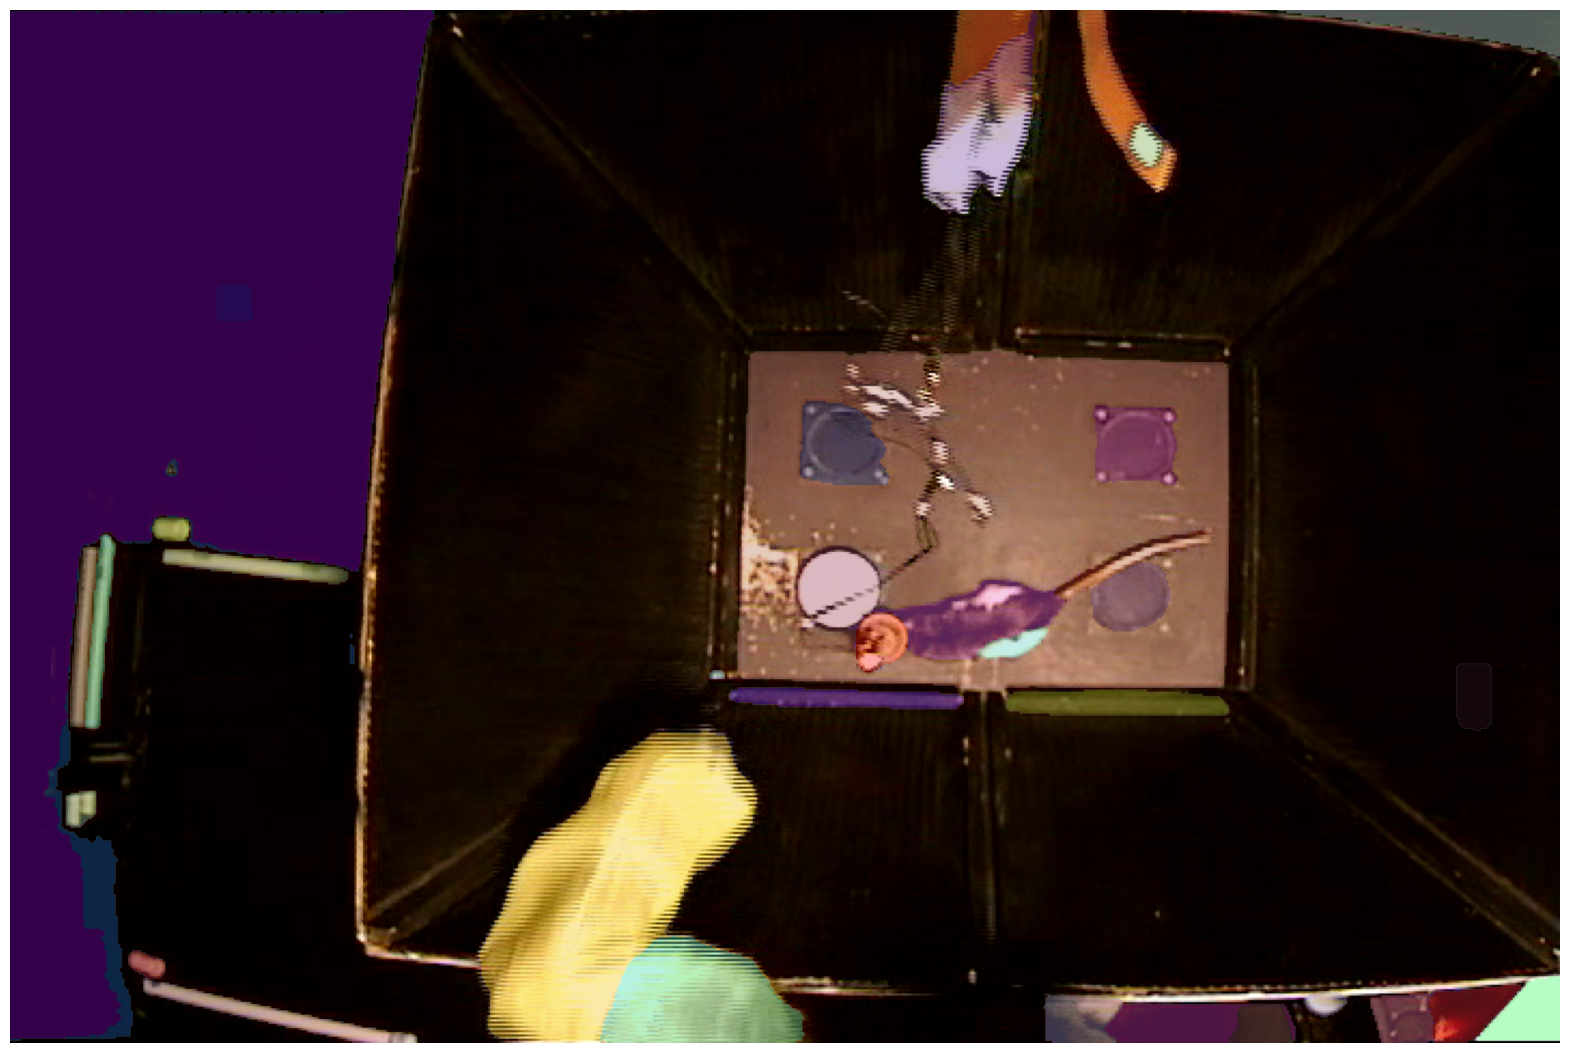

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [19]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [20]:
masks2 = mask_generator_2.generate(image)

In [21]:
len(masks2)

79

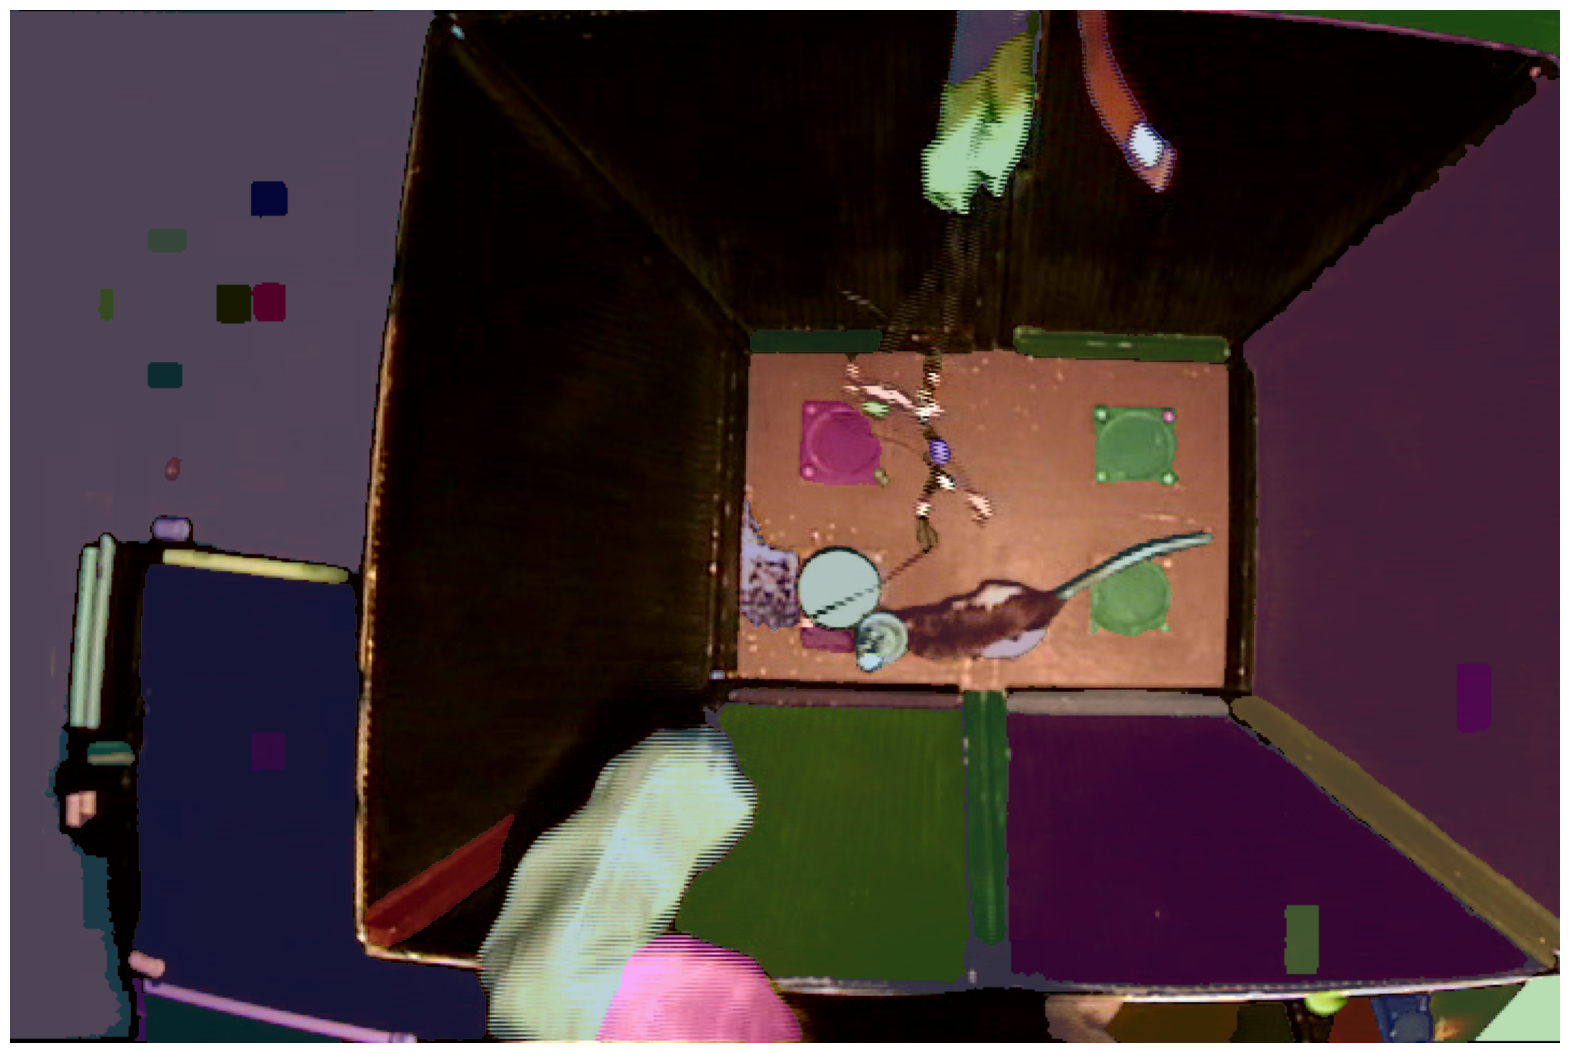

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [23]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def crop_image_with_masks(image, 
                          masks,
                          max_area=8000,
                          min_area=500, 
                          width_height_ratio=0.9):
    """
    Crop the image based on provided masks and apply the masks to each cropped region.

    Args:
        image (numpy.ndarray): The input image.
        masks (list): A list of dictionaries containing mask data.
        max_area (int): Max area of the mask
        min_area (int): Min area of the mask
        width_height_ratio(float): Min width / height

    Returns:
        list: A list of cropped images with applied masks.
    """
    cropped_images = []

    for mask_data in masks:
        # Extract mask and bounding box data
        bbox = mask_data['bbox']
        seg = mask_data['segmentation']
        x, y, w, h = bbox

        # Crop the image based on the bounding box
        cropped_image = image[y:y+h, x:x+w]

        # Create an 8-bit mask from the segmentation data
        mask = np.asarray(seg[y:y+h, x:x+w], dtype=np.uint8) * 255
        # Apply the mask to the cropped image
        cropped_image = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        if mask_data['area'] >= min_area and mask_data['area'] <= max_area and w/h >= width_height_ratio:
            cropped_images.append(cropped_image)

    return cropped_images

In [24]:
cropped_images = crop_image_with_masks(image,masks)

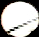

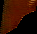

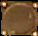

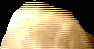

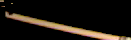

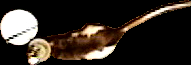

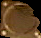

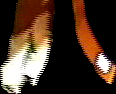

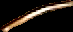

In [25]:
for cimg in cropped_images:
    cv2_imshow(cimg)

# Classify masks with openai/CLIP

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [26]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [27]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 141MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Setting up input images and texts

In [28]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images to use and their textual descriptions
descriptions = {
    "rat": "a small mammal with fur, long tail, and a white stripe on its back",
    "hand": "a human hand with fingers and palm",
    "arm": "a human arm extending from the shoulder to the hand",
    "cup": "a petri dish used for holding odor treated white or yellow sand",
    "book": "a bound collection of paper sheets used for writing or reading",
}


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.


In [29]:
class_names = list(descriptions.keys())
class_names

['rat', 'hand', 'arm', 'cup', 'book']

In [30]:
text_descriptions = [f"This is a photo of a {label}, {descriptions[label]}" for label in class_names]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [31]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [32]:
def get_top_probs_and_labels(image, masks, model, text_features):
    """
    Computes the top probabilities and labels for matching text and images.

    Args:
        image (ndarray): The input image.
        masks (ndarray): The masks for cropping the image.
        model: The CLIP model used for encoding image features.
        text_features: The text features used for comparison.

    Returns:
        top_probs (Tensor): Top probabilities of text matching for the cropped images.
        top_labels (Tensor): Top labels corresponding to the top probabilities.
    """
    # Crop images using masks
    cropped_images = crop_image_with_masks(image, masks)

    # Preprocess cropped images
    images = [preprocess(Image.fromarray(cimg)) for cimg in cropped_images]

    # Convert images to tensor and move to GPU
    image_input = torch.tensor(np.stack(images)).cuda()

    with torch.no_grad():
        # Encode image features
        image_features = model.encode_image(image_input).float()

        # Calculate text probabilities
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get top probabilities and labels
        top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

    return top_probs, top_labels


In [33]:
top_probs, top_labels = get_top_probs_and_labels(image, masks, model, text_features)

In [34]:
num_rows = int(np.ceil(len(cropped_images)/ 2))

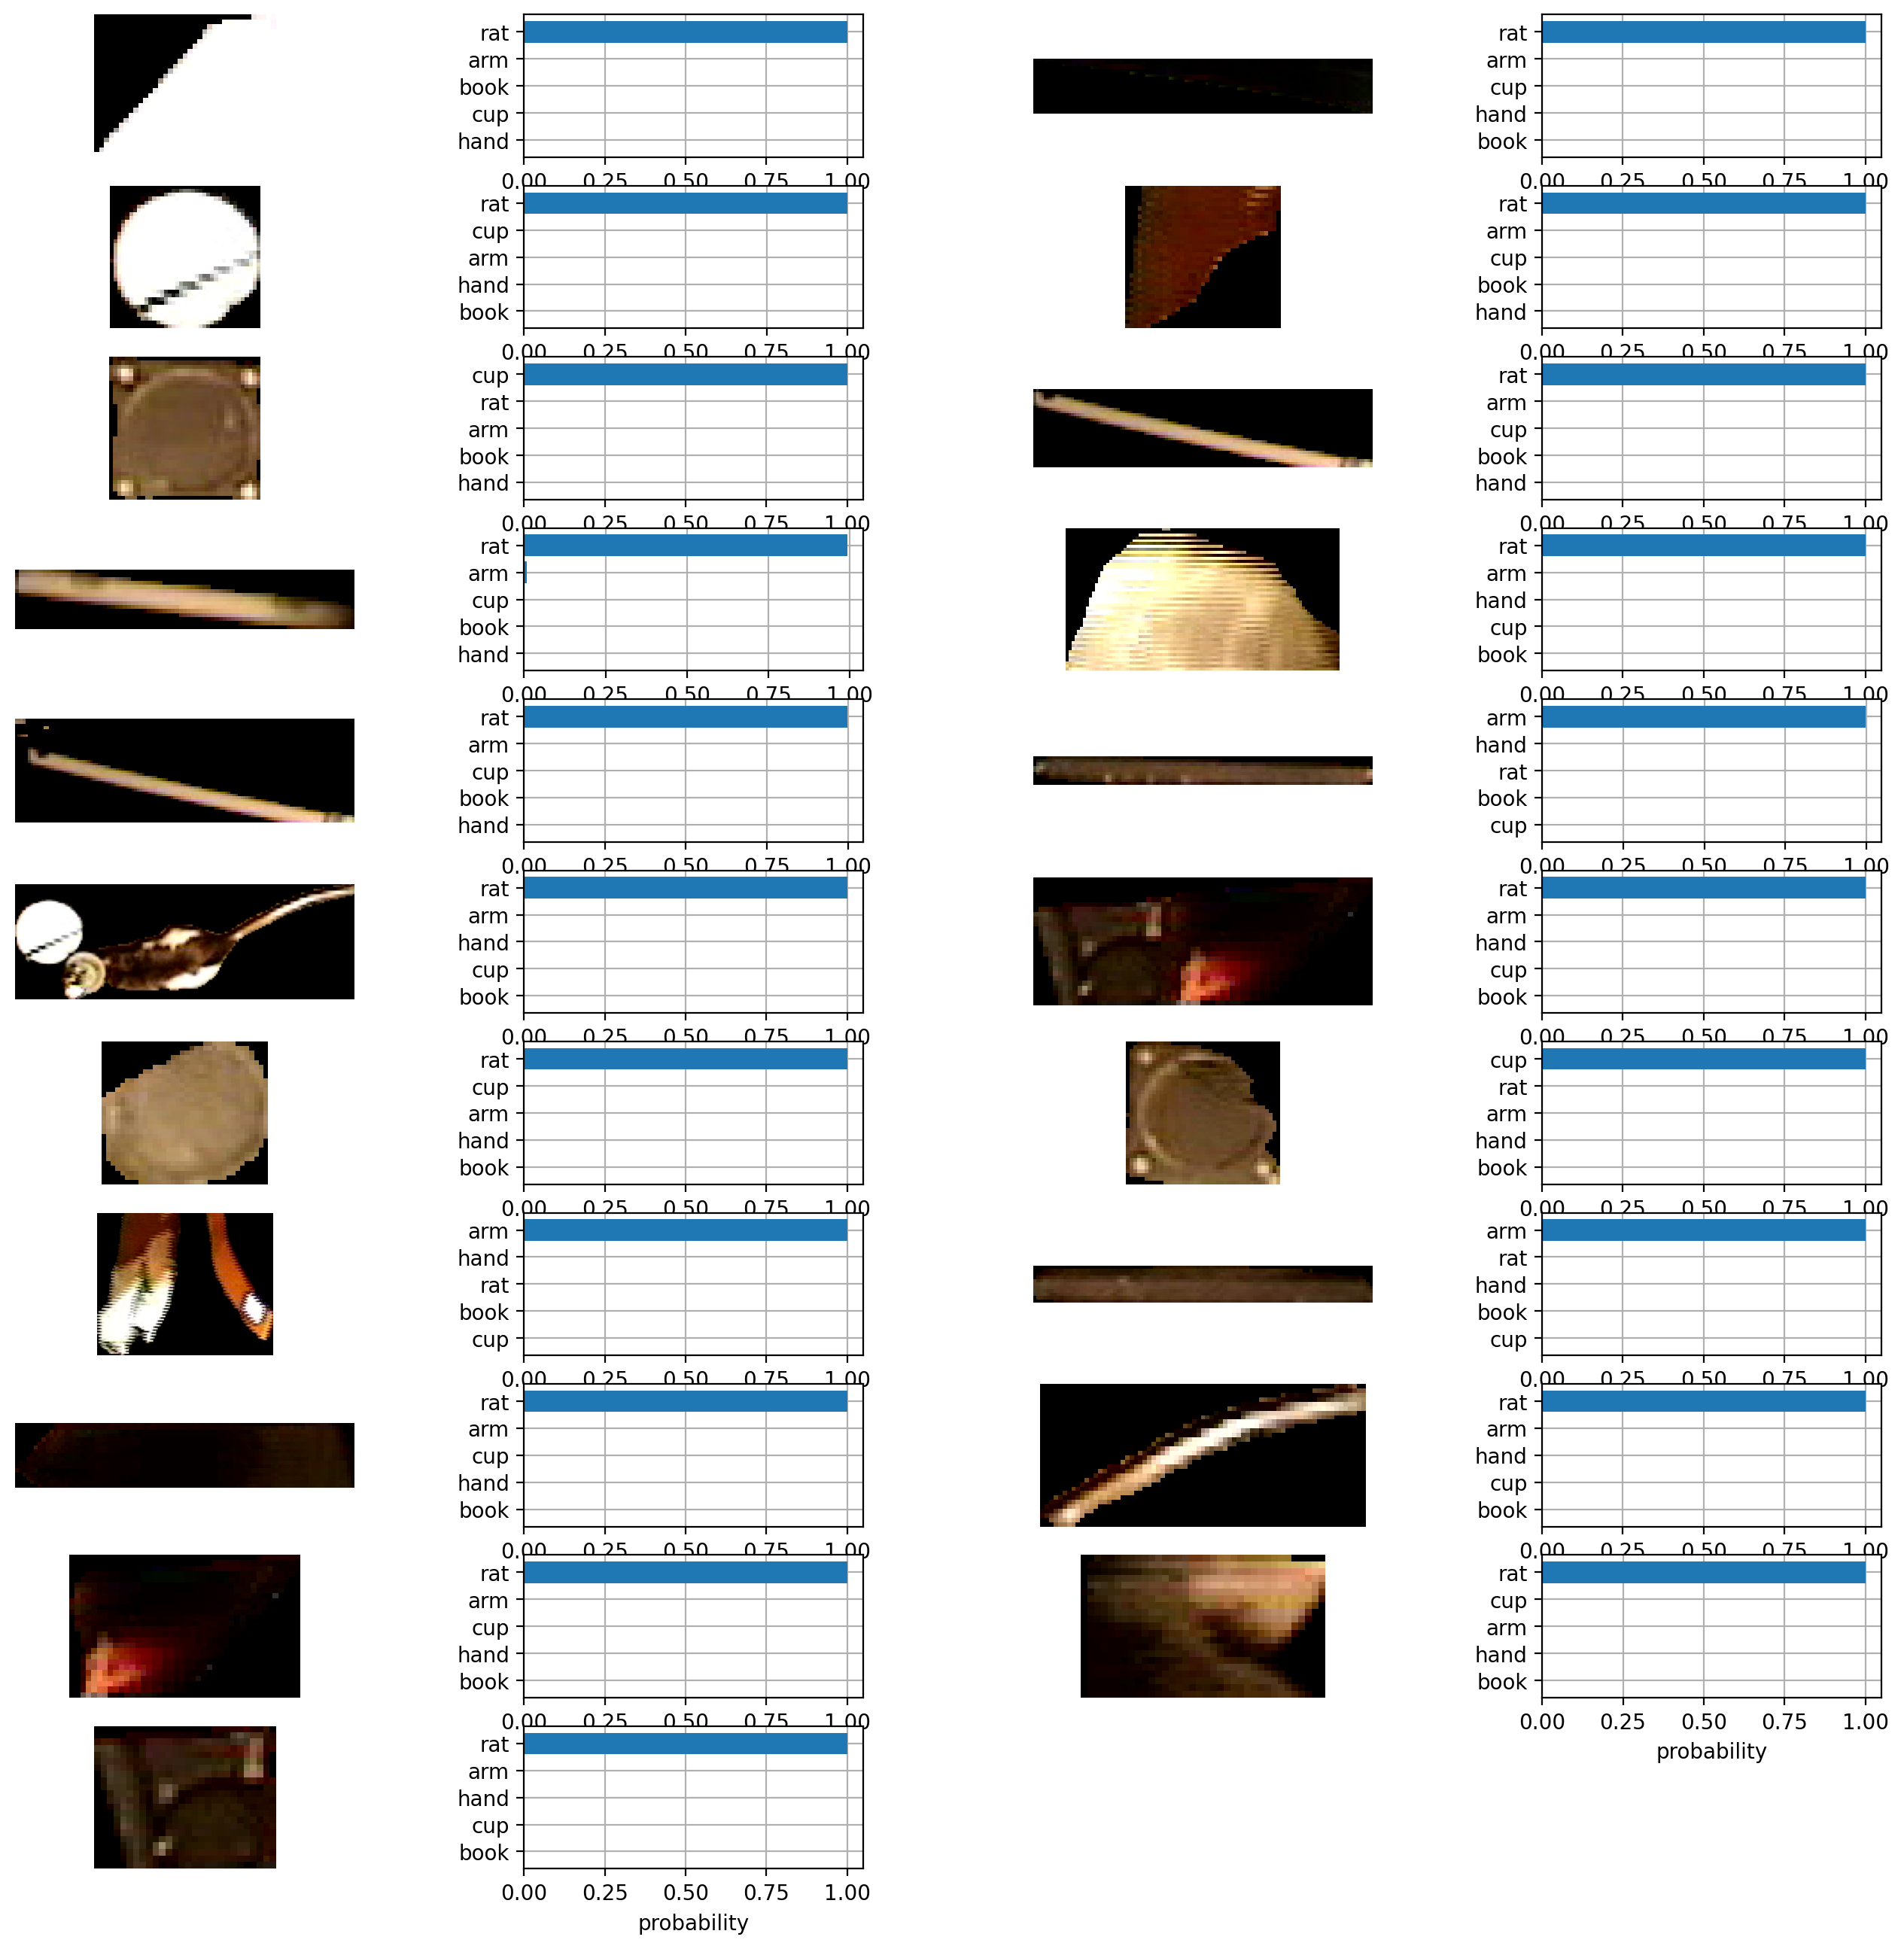

In [35]:
plt.figure(figsize=(16, 16))

for i, _image in enumerate(cropped_images):
    _image = cv2.cvtColor(_image,cv2.COLOR_BGR2RGB)
    plt.subplot(num_rows, 4, 2 * i + 1)
    plt.imshow(_image)
    plt.axis("off")

    plt.subplot(num_rows, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [36]:
import pycocotools.mask as mask_util
def convert_to_annolid_format(frame_number, masks):
    """Converts predicted SAM masks information to annolid format.

    Args:
        frame_number (int): The frame number associated with the masks.
        masks (list): List of dictionaries representing the predicted masks.
            Each dictionary should contain the following keys:
                -segmentation : the mask
                -area : the area of the mask in pixels
                -bbox : the boundary box of the mask in XYWH format
                -predicted_iou : the model's own prediction for the quality of the mask
                -point_coords : the sampled input point that generated this mask
                -stability_score : an additional measure of mask quality
                -crop_box : the crop of the image used to generate this mask in XYWH format

    Returns:
        list: List of dictionaries representing the masks in annolid format.
            Each dictionary contains the following keys:
                - "frame_number": The frame number associated with the masks.
                - "x1", "y1", "x2", "y2": The coordinates of the bounding box in XYXY format.
                - "instance_name": The name of the instance/object.
                - "class_score": The predicted IoU (Intersection over Union) for the mask.
                - "segmentation": The segmentation mask.
                - "tracking_id": The tracking ID associated with the mask.

    """
    pred_rows = []
    for mask in masks:
        x1 = mask.get("bbox")[0]
        y1 = mask.get("bbox")[1]
        x2 = mask.get("bbox")[0] + mask.get("bbox")[2]
        y2 = mask.get("bbox")[1] + mask.get("bbox")[3]
        instance_name = mask.get("instance_name", 'object')
        score = mask.get("predicted_iou", '')
        segmentation = mask.get("segmentation", '')
        segmentation = mask_util.encode(segmentation)
        tracking_id = mask.get("tracking_id", "")

        pred_rows.append({
            "frame_number": frame_number,
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2,
            "instance_name": instance_name,
            "class_score": score,
            "segmentation": segmentation,
            "tracking_id": tracking_id
        })

    return pred_rows

In [37]:
predict_rows = convert_to_annolid_format(100275,masks)

In [38]:
import pandas as pd
df = pd.DataFrame(predict_rows)
df.head()

frame_number   x1   y1   x2   y2 instance_name  class_score  \
0        100275  682  449  719  478        object     1.003545   
1        100275    0    0  196  477        object     0.998091   
2        100275  218  335  367  478        object     0.992224   
3        100275    0    0  684  478        object     0.990410   
4        100275  589    0  719   21        object     0.988739   

                                        segmentation tracking_id  
0  {'size': [480, 720], 'counts': b'mTP:2m>1N2O1O...              
1  {'size': [480, 720], 'counts': b'1m>3000000000...              
2  {'size': [480, 720], 'counts': b'ecV35j>8G5J5M...              
3  {'size': [480, 720], 'counts': b'1n>200000000O...              
4  {'size': [480, 720], 'counts': b'PSd81o>000000...

In [111]:
df.to_csv("rats_v1_coco_dataset_R2202_02-10-2023_mask_rcnn_tracking_results_with_segmentation.csv")

# Example video

In [ ]:
!wget https://storage.googleapis.com/sleap-data/datasets/eleni_mice/clips/20200111_USVpairs_court1_M1_F1_top-01112020145828-0000%400-2560.mp4

In [47]:
original_video_file = "/content/20200111_USVpairs_court1_M1_F1_top-01112020145828-0000@0-2560.mp4"
video_file = '/content/usvpairs_court1.mp4'

## Cut 2s of the video starting from second 30

In [ ]:
!ffmpeg -i {original_video_file} -ss 00:00:30 -t 00:00:02 -c:v copy -c:a copy {video_file}

In [51]:
import decord as de
import pandas as pd

def process_video_and_save_tracking_results(video_file, mask_generator):
    """
    Process a video file, generate tracking results with segmentation masks,
    and save the results to a CSV file.

    Args:
        video_file (str): Path to the video file.
        mask_generator: An instance of the mask generator class.

    Returns:
        None
    """
    video_reader = de.VideoReader(video_file)
    tracking_results = []

    for key_index in video_reader.get_key_indices():
        frame = video_reader[key_index].asnumpy()
        masks = mask_generator.generate(frame)
        tracking_results += convert_to_annolid_format(key_index, masks)
        print(key_index)

    dataframe = pd.DataFrame(tracking_results)
    output_file = f"{video_file.split('.')[0]}_mask_tracking_results_with_segmentation.csv"
    dataframe.to_csv(output_file)
    return output_file

In [ ]:
tracking_results_file = process_video_and_save_tracking_results(video_file, mask_generator)

In [53]:
from google.colab.files import download

In [54]:
download(tracking_results_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
download(video_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>